In [1]:
%matplotlib notebook

from ipywidgets import interact
import ipywidgets as widgets

from matplotlib import pyplot as plt
from matplotlib import rc
from pandas import read_csv
import os
import numpy as np
import seaborn as sns


%matplotlib inline
%config InlineBackend.figure_format='retina'

rc('font', size=16)
rc('axes', titlesize=18)
rc('axes', labelsize=18)

## Question

Given a 1.024 sscond window sampled 12500 times (81.92 microseconds), 
how many samples of a dispersed pulse can appear 
in the window given the pulse's DM? 


In [2]:
def plot_spectrum(data, ncols=1, nrows=1):
    fig, ax = plt.subplots(figsize=(10, 5), ncols=ncols, nrows=nrows)
    ax.plot(data, extent='lower')
    ax.set_xlabel('channel')
    ax.set_ylabel('intensity')

def plot_image(data, 
               xticks=[], xtick_labels=[], 
               yticks=[], ytick_labels=[], 
               ncols=1, nrows=1, 
               xfig_size=10, yfig_size=5
              ):
    fig, ax = plt.subplots(figsize=(xfig_size, yfig_size), ncols=ncols, nrows=nrows)
    ax.imshow(data, origin='lower')
    ax.set_xlabel('time (s)')
    ax.set_ylabel('frequency (MHz)')
    
    if len(xticks) > 0 and len(xtick_labels) > 0:
        ax.set_xticks(xticks)
        ax.set_xticklabels(xtick_labels)   
    
    if len(yticks) > 0 and len(ytick_labels) > 0:
        ax.set_yticks(yticks)
        ax.set_yticklabels(ytick_labels)
        
def plot_multi_images(data_arr,
                  xticks=[], xtick_labels=[], 
                  yticks=[], ytick_labels=[], 
                  direction='horizontal',
                  xfig_size=10, yfig_size=5,
                  spectrum=False
                 ):
    
    if direction == 'horizontal':
        ncols=len(data_arr)
        nrows=1
    elif direction == 'vertical':
        ncols=1
        nrows=len(data_arr)
    
    fig, ax = plt.subplots(figsize=(xfig_size, yfig_size), ncols=ncols, nrows=nrows)
    
    for i in range(len(data_arr)):
        im = ax[i].imshow(data_arr[i], origin='lower')
        if spectrum:
            ax[i].autoscale(False)
            ax2 = ax[i].twinx()
            ax2.plot(data_arr[i].sum(axis=0), color='black', alpha=0.5)
            ax2.set_ylabel('S/N')
        fig.colorbar(im, ax=ax[i])      
        
    if len(xticks) > 0 and len(xtick_labels) > 0:
        for i in range(len(ax)):
            if (direction == 'vertical' and i == len(ax)-1) or direction == 'horizontal':
                ax[i].set_xlabel('Time (s)')
                ax[i].set_xticks(xticks)
                ax[i].set_xticklabels(xtick_labels)
            else:
                plt.setp(ax[i].get_xticklabels(), visible=False)
            
    if len(yticks) > 0 and len(ytick_labels) > 0:
        for i in range(len(ax)):
            if (direction == 'horizontal' and i == 0) or direction == 'vertical':
                ax[i].set_ylabel('Frequency (MHz)')
                ax[i].set_yticks(yticks)
                ax[i].set_yticklabels(ytick_labels)
            else:
                plt.setp(ax[i].get_yticklabels(), visible=False)
                

    plt.tight_layout()

def generate_gaussian_data(n_samples, n_channels):
    return np.random.normal(0, 1, (n_channels, n_samples))

class RFIm():
    def __init__(self):
        pass
    
    def fdsc(self, data, bin_size=32, threshold=2.75):
        dtmean = np.mean(data, axis=-1)
        dtmean_nobandpass = data.mean(1) - dtmean.reshape(-1, bin_size).mean(-1).repeat(bin_size)
        stdevt = np.std(dtmean_nobandpass)
        medt = np.mean(dtmean_nobandpass)
        maskt = np.abs(dtmean_nobandpass - medt) > threshold*stdevt
        data[maskt] = np.median(dtmean)
        return data

    def fdsc_old(self, data, bin_size=32, threshold=2.75, n_iter=1):
        for j in range(n_iter):
            dtmean = np.mean(data, axis=-1)
            for i in range(data.shape[1]):
                dtmean_nobandpass = data[:, i] - dtmean.reshape(-1, bin_size).mean(-1).repeat(bin_size)
                stdevt = np.std(dtmean_nobandpass)
                # medt = np.median(dtmean_nobandpass)
                medt = np.mean(dtmean_nobandpass)
                maskt = np.abs(dtmean_nobandpass - medt) > threshold*stdevt

                # replace with mean bin values
                data[maskt, i] = dtmean.reshape(-1, bin_size).mean(-1).repeat(bin_size)[maskt]

        return data
    
    def fdsc_amber(self, data, bin_size=32, threshold=2.75, n_iter=1):
        for k in range(n_iter):            
            for t in range(data.shape[1]):
                current = data[:, t]
                dtmean_nobandpass = current - current.reshape(-1, bin_size).mean(-1).repeat(bin_size)
                stdevt = np.std(dtmean_nobandpass)
                # medt = np.median(dtmean_nobandpass)
                medt = np.mean(dtmean_nobandpass)
                maskt = dtmean_nobandpass > medt + threshold*stdevt

                # replace with mean bin values
                data[maskt, t] = current.reshape(-1, bin_size).mean(-1).repeat(bin_size)[maskt]

        return data
    
    def tdsc(self, data, threshold=3.25, n_iter=1):
        dtmean = np.mean(data, axis=-1)
        for i in range(n_iter):
            dfmean = np.mean(data, axis=0)
            stdevf = np.std(dfmean)
            medf = np.median(dfmean)
            maskf = np.where(np.abs(dfmean - medf) > threshold*stdevf)[0]
            # replace with mean spectrum
            data[:, maskf] = dtmean[:, None]*np.ones(len(maskf))[None]
            
        return data
    
    def tdsc_amber(self, data, threshold=3.25, n_iter=1):
        for k in range(n_iter):            
            for f in range(data.shape[0]):
                dfmean = np.mean(data[f, :])
                stdevf  = np.std(data[f, :])
                maskf = np.where(data[f, :] > dfmean + threshold*stdevf)[0]
                
                data[f, maskf] = dfmean
                
        return data
    
    def tdsc_per_channel(self, data, threshold=3.25, n_iter=1):
        for ii in range(n_iter):
            dtmean = np.mean(data, axis=1, keepdims=True)
            dtsig = np.std(data, axis=1)
            for nu in range(data.shape[0]):
                d = dtmean[nu]
                sig = dtsig[nu]
                maskpc = np.where(np.abs(data[nu]-d)>threshold*sig)[0]
                data[nu][maskpc] = d
                
        return data

In [3]:
class Backend():   
    # Defaults are currently ARTS observing properties
    def __init__(self, 
                 n_channels:int = 1536,
                 channel_bandwidth:float = 0.1953125, # MHz
                 fmin:float = 1219.700927734375, # MHz
                 sampling_time:float = 0.00008192, # second
                 samples_per_second:int = 12500,
                ):
        
        self.n_channels = n_channels
        self.channel_bandwidth = channel_bandwidth
        self.fmin = fmin
        self.fmax = self.fmin+self.n_channels*self.channel_bandwidth # MHz
        self.sampling_time = sampling_time
        self.samples_per_second = samples_per_second
        
        self.freq_to_index = lambda frequency : int((frequency-self.fmin)/self.channel_bandwidth)
        self.next_freq = lambda i : self.fmin + i * self.channel_bandwidth
        self.frequencies = np.array([self.next_freq(i) for i in range(self.n_channels)])
        self.freq_indices = np.array([self.freq_to_index(f) for f in self.frequencies])
    
class Observation():
    def __init__(self, 
                 backend:Backend,
                 length:int = 1, # length in second
                 t0:float = 0.
                ):
        self.backend = backend
        self.length = length
        self.t0 = t0
        self.window = np.random.normal(0, 1, (self.backend.n_channels, 
                                              int(self.length*backend.samples_per_second)))    
        self.noise_median = np.median(self.window).copy()
        self.noise_std = np.std(self.window).copy()
        
        # Time
        self.time_to_index = lambda t_i : np.ceil((t_i-self.t0)/self.backend.sampling_time).astype(int)
        self.index_to_time = lambda index : index * self.backend.sampling_time + self.t0
        self.next_time = lambda i : i * self.backend.sampling_time
            
        self.times = np.array([self.next_time(i) for i in range(int(self.backend.samples_per_second * 
                                                                    self.length))])
        self.time_indices = np.array([self.time_to_index(t) for t in self.times])
        
    def time_cleaning(self, window=None, keep_state=False):
        if keep_state:
            if window == None:
                window = rfim.tdsc_amber(self.window)
            else:
                window = rfim.tdsc_amber(window)
        else:
            if window == None:
                return rfim.tdsc_amber(self.window)
            else:
                return rfim.tdsc_amber(window)
            
        self.window = window
        return window
    
    def frequency_cleaning(self, window=[], keep_state=False):
        if keep_state:
            if len(window) == 0:
                window = rfim.fdsc_amber(self.window)
            else:
                window = rfim.fdsc_amber(window)
        else:
            if len(window) == 0:
                return rfim.fdsc_amber(self.window)
            else:
                return rfim.fdsc_amber(window)

        self.window = window
        return window
        
    def dedisperse(self, dm):
        return np.array([
            np.roll(self.window[i].copy(), -r) for i, r in zip(
                range(self.window.shape[0]), 
                self.time_to_index(Pulse(self.backend).delays(dm))
            )
        ])
        
    def add_signal(self, signal_value, x_t0, x_t1, y_t0, y_t1):
        self.window[x_t0:x_t1, y_t0:y_t1] = signal_value
        
    def add_dispersed_pulse(self, dm, width, pulse_t0, snr=100):
        pulse = Pulse(self.backend, width=width)
        pulse_t_start = obs.index_to_time(index=self.time_to_index(pulse_t0).astype(int))
        value = ((self.noise_median + self.noise_std*snr)/self.backend.n_channels) 
        t_idx = self.time_to_index(t_i=pulse_t_start+pulse.delays(dm=dm))

        for i in range(t_idx.shape[0]):
            self.add_signal(value, i, i+1, t_idx[i], t_idx[i]+self.time_to_index(pulse.width))
                        
    def add_rfi(self, 
                t_start:float=0, 
                t_stop:float=10, 
                t_step:float=100,
                f_start=200, f_stop=250,
                width=10,
                snr=50,
               ):
        
        start = self.time_to_index(t_start)
        stop = self.time_to_index(t_stop)
        step = self.time_to_index(t_step)
        width = self.time_to_index(width)
        
        value = (self.noise_median + snr * self.noise_std)/np.ceil((stop-start)/(step*width)).astype(int)
        
        for t in range(start, stop, step):
            obs.add_signal(value, f_start, f_stop, t, t+width)
            
#     def add_signal(self, signal, t_start):
#         self.observation_window[t] += 
        
class Pulse():
    def __init__(self, 
                 backend:Backend = Backend(),
                 width:int = 10,
                ):
        self.backend = backend
        self.width = width
       
        # Frequency delay        
        self.dt = lambda dm, f_i : (4.148808 * 1000 * (f_i**-2 - self.backend.fmax**-2)) * dm 
    def delays(self, dm): 
        """Create an array of delays (in second) for each backend frequency channel 
        
        Parameters
        ----------
        dm:int
            Value for dispersion measure of the pulse

        Returns
        -------
        delays:Numpy.array
            Array of delays
        """
        return np.array([self.dt(dm, f) for f in  self.backend.frequencies])
                
    def plot_delay_v_frequency(self, dm, xscale='linear'):
        ncols=1
        nrows=1
        fig, ax = plt.subplots(figsize=(10, 5), ncols=ncols, nrows=nrows)
        ax.plot(self.delays(dm), self.backend.frequencies)
        ax.set_xlabel('Delay (s)')
        ax.set_ylabel('Frequency (MHz)')
        if xscale:
            ax.set_xscale(xscale)
        
    def plot_delay_v_frequency_interactive(self, xscale='linear', dm_min=0, dm_max=5000, dm_step=5, dm_init=0):
        interact(
            self.plot_delay_v_frequency, 
            dm=widgets.IntSlider(min=dm_min, max=dm_max, step=dm_step, value=dm_init),
            xscale=xscale,
        )


# ARTS setup

In [ ]:
# obs = Observation(fmin=120, n_channels=3000, channel_bandwidth=0.4665669759)
pulse = Pulse(Backend())
pulse.plot_delay_v_frequency_interactive(xscale='linear')

# Apertif to LOFAR HBA

In [ ]:
fmin = 120
n_channels = 3000
channel_bandwidth = (Backend().fmax-fmin)/n_channels

pulse = Pulse(Backend(fmin=fmin, n_channels=n_channels, channel_bandwidth=channel_bandwidth))
pulse.plot_delay_v_frequency_interactive(xscale='linear', dm_init=3000)

# Testing
### Pulsar/FRB and RFI injection and test RFIm

In [8]:
obs = Observation(Backend(), length=1.024)
raw = obs.window.copy()
obs.add_dispersed_pulse(dm=1000, width=0.006, pulse_t0=0.16, snr=400)
# obs.add_dispersed_pulse(dm=1, width=0.006, pulse_t0=0.33, snr=50)
# obs.add_dispersed_pulse(dm=10, width=0.006, pulse_t0=0.73, snr=15)

# for f1, f2 in [
#     #[100, 132],
#     [560, 575],
# #     [1220, 1265]
# #     [obs.backend.freq_to_index(1340), obs.backend.freq_to_index(1345)], 
# #     [obs.backend.freq_to_index(1360), obs.backend.freq_to_index(1370)]
# ]:
#     obs.add_rfi(
#         t_start=0., 
#         t_stop=0.5, 
#         t_step=0.03,
#         f_start=f1, f_stop=f2,
#         width=0.01,
#         snr=20,
#     )

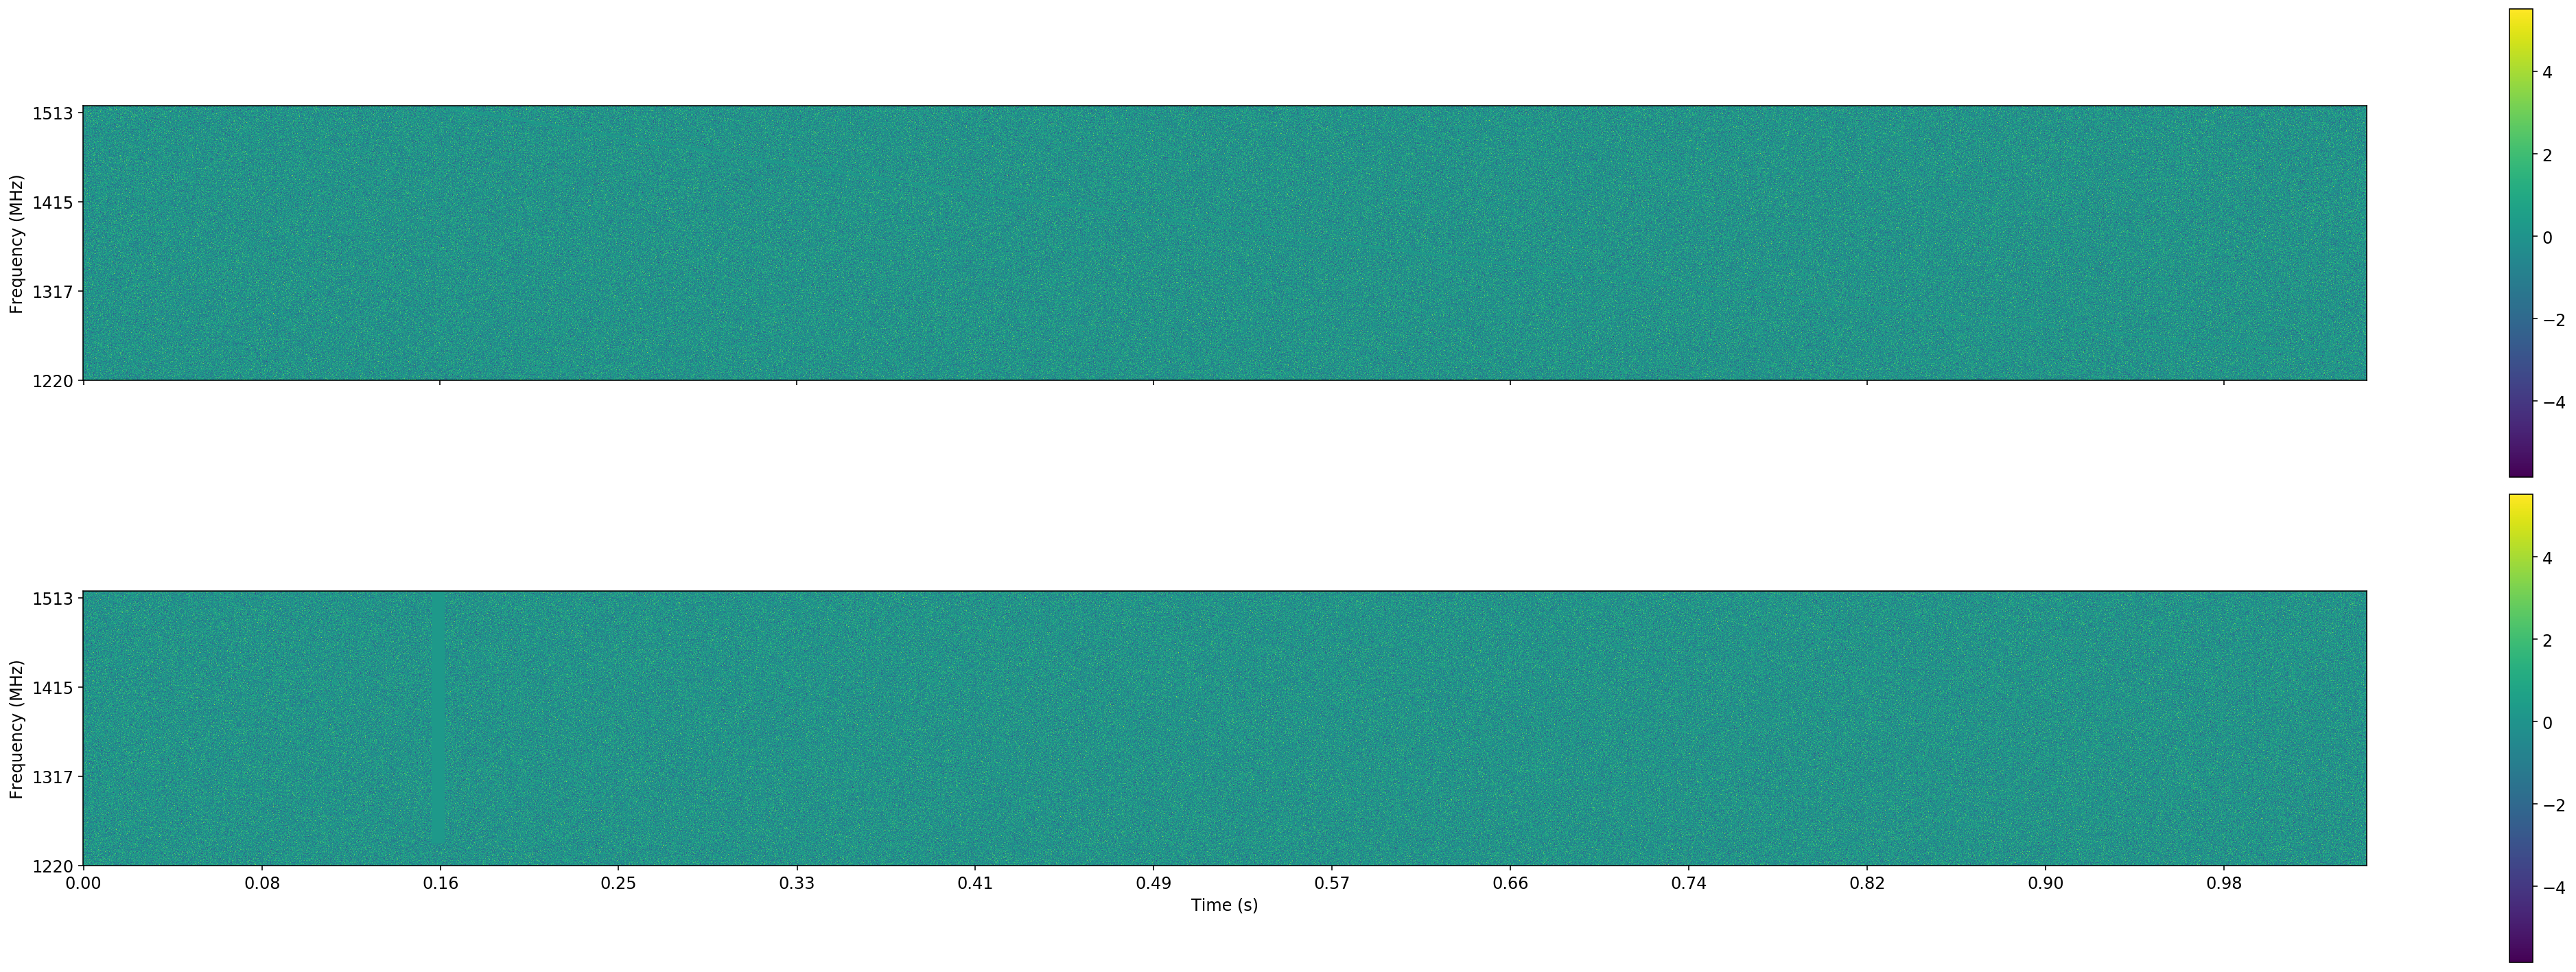

In [9]:
rfim = RFIm()

# window_fdsc_amber = rfim.fdsc_amber(obs.window.copy(), threshold=2.75)
# window_tdsc_amber = rfim.tdsc_amber(obs.window.copy())
# window_both = rfim.fdsc_amber(rfim.tdsc_amber(obs.window.copy()))

xstep = 1000
ystep = 500

rc('font', size=12)
rc('axes', titlesize=12)
rc('axes', labelsize=12)

o_window = obs.window.copy()
# o_tc = obs.time_cleaning().copy()
# o_fc = obs.frequency_cleaning().copy()

plot_multi_images(
#     (raw, obs.window, window_fdsc_amber, window_tdsc_amber, window_both), 
    (
#         raw,
        o_window, 
#         o_tc,
#         o_fc,
#         obs.frequency_cleaning(obs.time_cleaning(), keep_state=True),
        obs.dedisperse(dm=1000),
#         obs.dedisperse(dm=1000)[]
    ),
#     (obs.window, window_fdsc, window_fdsc_per_channel, window_tdsc, window_tdsc_per_channel), 
    direction='vertical', 
    
    xticks=obs.time_indices[::xstep],
    xtick_labels=["%.2f" % t for t in obs.times[::xstep]],
    
    yticks=obs.backend.freq_indices[::ystep], 
    ytick_labels=["%.0f" % f for f in obs.backend.frequencies[::ystep]],

    xfig_size = 30,
    yfig_size = 10,
    spectrum=False
)

In [ ]:
dtmean.reshape(-1, bin_size).shape

In [ ]:
dtmean.shape

In [ ]:
d = np.random.normal(0, 1, (10, 100))
1536 * ((np.median(d) + d.std()*10)/1536)

In [ ]:
a = np.asarray([[0, 1,2,3], [4,5,6,7], [8, 9, 10, 11,]])

In [ ]:
obs.window[0].roll()

In [ ]:
obs.time_to_index(Pulse(obs.backend).delays(dm=1000))